In [1]:
import os
import tensorflow as tf

In [2]:
#loading compressed models from tf hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [3]:
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mp
mp.rcParams['figure.figsize'] = (12,12)
mp.rcParams['axes.grid'] = False

In [4]:
import numpy as np
import PIL.Image
import time
import functools

In [5]:
#converting tensor to image
def tensor_to_image(tensor):
    tensor=np.array(tensor*255,dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0]==1
        tensor=tensor[0]
    return PIL.Image.fromarray(tensor)

In [6]:
#let's get some images from google
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

196608/195196 [==============================] - 0s 0us/step


In [7]:
print(content_path)
print(style_path)

/root/.keras/datasets/YellowLabradorLooking_new.jpg
/root/.keras/datasets/kandinsky5.jpg


In [8]:
#load image from given path
def load_img(path):
    max_dim=512
    img=tf.io.read_file(path)
    img=tf.image.decode_image(img,channels=3)
    img=tf.image.convert_image_dtype(img,tf.float32)
    shape=tf.cast(tf.shape(img)[:-1],tf.float32)
    print("Original shape: ",shape)
    long_dim=max(shape)
    scale=max_dim/long_dim
    new_shape=tf.cast(shape*scale,tf.int32)
    print("New shape: ",new_shape)
    img=tf.image.resize(img,new_shape)
    img=img[tf.newaxis,:]
    return img

In [9]:
load_img(content_path)

Original shape:  tf.Tensor([577. 700.], shape=(2,), dtype=float32)
New shape:  tf.Tensor([422 512], shape=(2,), dtype=int32)


<tf.Tensor: shape=(1, 422, 512, 3), dtype=float32, numpy=
array([[[[0.6290779 , 0.64868575, 0.38986227],
         [0.6007131 , 0.62248087, 0.3679772 ],
         [0.5896757 , 0.61320513, 0.3622247 ],
         ...,
         [0.5269978 , 0.55837035, 0.32699776],
         [0.49909076, 0.5304633 , 0.29732907],
         [0.47968566, 0.5110583 , 0.27576408]],

        [[0.6060711 , 0.6300001 , 0.36901602],
         [0.60180223, 0.62551117, 0.3700369 ],
         [0.6003996 , 0.623929  , 0.37294865],
         ...,
         [0.52357244, 0.554945  , 0.32141185],
         [0.5284101 , 0.5597826 , 0.3254584 ],
         [0.53133637, 0.5627089 , 0.3274148 ]],

        [[0.58011585, 0.60756683, 0.3448217 ],
         [0.5973071 , 0.6225982 , 0.36633283],
         [0.60061604, 0.6340622 , 0.3797762 ],
         ...,
         [0.530031  , 0.5614036 , 0.32610947],
         [0.5510388 , 0.58241135, 0.34711725],
         [0.55976367, 0.5911362 , 0.35584208]],

        ...,

        [[0.43124956, 0.40153953, 

In [40]:
#let's create a funtion to display image
def display_img(image,title=None):
    if len(image.shape)>3:
        image=tf.squeeze(image,axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

Original shape:  tf.Tensor([577. 700.], shape=(2,), dtype=float32)
New shape:  tf.Tensor([422 512], shape=(2,), dtype=int32)


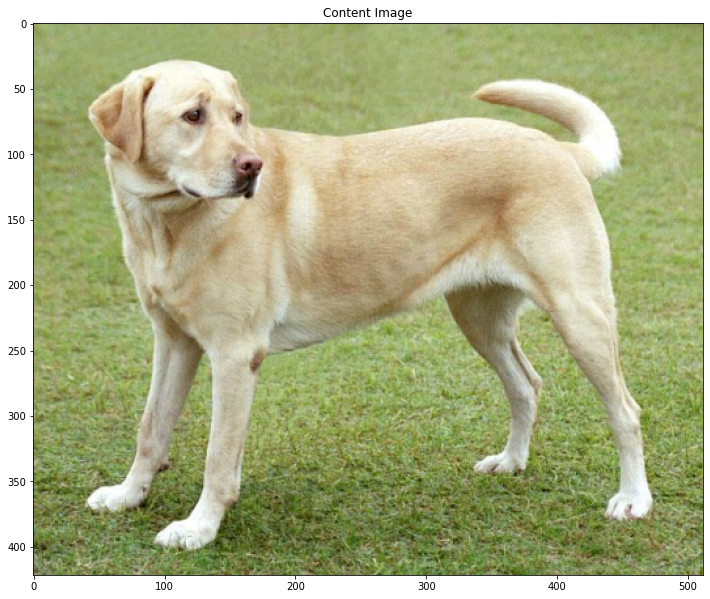

In [41]:
display_img(load_img(content_path),title="Content Image")

Original shape:  tf.Tensor([ 657. 1000.], shape=(2,), dtype=float32)
New shape:  tf.Tensor([336 512], shape=(2,), dtype=int32)


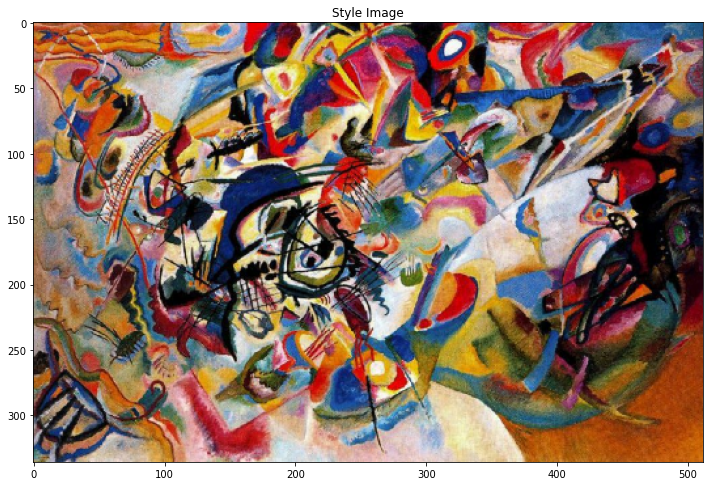

In [42]:
display_img(load_img(style_path),title="Style Image")

In [43]:
#let's do fast style transfer using tf hub
import tensorflow_hub as hub
hub_model=hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image=hub_model(tf.constant(load_img(content_path)),tf.constant(load_img(style_path)))[0]
tensor_to_image(stylized_image)

Original shape:  tf.Tensor([577. 700.], shape=(2,), dtype=float32)
New shape:  tf.Tensor([422 512], shape=(2,), dtype=int32)
Original shape:  tf.Tensor([ 657. 1000.], shape=(2,), dtype=float32)
New shape:  tf.Tensor([336 512], shape=(2,), dtype=int32)


In [44]:
#now let's do style transfer without using th fub
#load vgg19
content_image=load_img(content_path)
style_image=load_img(style_path)
x=tf.keras.applications.vgg19.preprocess_input(content_image*255)
x=tf.image.resize(x,(224,224))
vgg=tf.keras.applications.VGG19(include_top=True,weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

Original shape:  tf.Tensor([577. 700.], shape=(2,), dtype=float32)
New shape:  tf.Tensor([422 512], shape=(2,), dtype=int32)
Original shape:  tf.Tensor([ 657. 1000.], shape=(2,), dtype=float32)
New shape:  tf.Tensor([336 512], shape=(2,), dtype=int32)


TensorShape([1, 1000])

In [45]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('Labrador_retriever', 0.49317136),
 ('golden_retriever', 0.23665282),
 ('kuvasz', 0.036357533),
 ('Chesapeake_Bay_retriever', 0.024182757),
 ('Greater_Swiss_Mountain_dog', 0.01864606)]

In [46]:
#layers in VGG 19
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
for layer in vgg.layers:
    print(layer.name)

input_6
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [47]:
content_layers=['block5_conv2']
style_layers=['block1_conv1',
              'block2_conv1',
              'block3_conv1', 
              'block4_conv1', 
              'block5_conv1']

In [48]:
num_content_layers=len(content_layers)
num_style_layers=len(style_layers)
print("No of content layers: ",num_content_layers)
print("No of style layers: ",num_style_layers)

No of content layers:  1
No of style layers:  5


In [49]:
#let's build the model
def vgg_layers(layer_names):
    vgg=tf.keras.applications.VGG19(include_top=False,weights='imagenet')
    vgg.trainable=False
    outputs=[vgg.get_layer(name).output for name in layer_names]
    model=tf.keras.Model([vgg.input],outputs)
    return model

In [50]:
#let's create the model
style_extractor=vgg_layers(style_layers)
style_outputs=style_extractor(style_image*255)
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5256
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.8857
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.24
  mean:  230.78104

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.135
  mean:  791.2401

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.254
  mean:  59.179478



https://www.youtube.com/watch?v=z5x-Mh9wiqA

https://github.com/akkinasrikar/Deeplearning.ai-Andrew-NG-Slides/tree/main/4-Convolutional%20Neural%20Networks/week%204

In [51]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [52]:
#Extract style and content
class StyleContentModel(tf.keras.models.Model):
    
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
        
    def call(self,inputs):
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)

        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

In [53]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

In [54]:
print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.005522845
    max:  28014.555
    mean:  263.79022

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  61479.49
    mean:  9100.949

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  545623.44
    mean:  7660.976

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4320501.5
    mean:  134288.84

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  110005.36
    mean:  1487.0378

Contents:
   block5_conv2
    shape:  (1, 26, 32, 512)
    min:  0.0
    max:  2410.879
    mean:  13.764149


In [55]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [56]:
image = tf.Variable(content_image)

In [57]:
def clip_image_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [58]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [59]:
style_weight=1e-2
content_weight=1e4

In [60]:
#loss=(1/5)*alpha*style loss+(1/1)*beta*content loss
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [61]:
#Use tf.GradientTape to update the image.
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_image_0_1(image))

In [62]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

In [63]:
from IPython import display

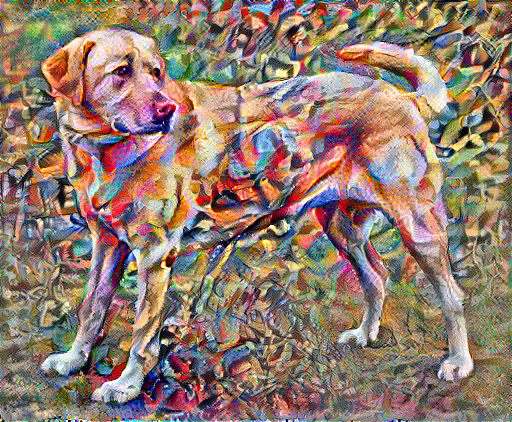

Train step: 1000
Total time: 80.0


In [64]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
    print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [65]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

In [68]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
display_img(clip_image_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
display_img(clip_image_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
display_img(clip_image_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
display_img(clip_image_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

In [69]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [70]:
total_variation_loss(image).numpy()

149341.44

In [71]:
total_variation_weight=30

In [75]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_image_0_1(image))

In [76]:
image = tf.Variable(content_image)

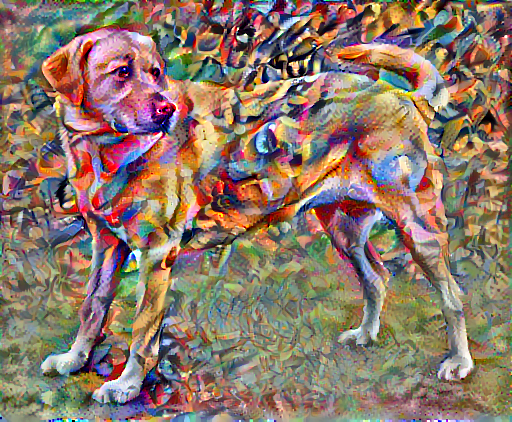

Train step: 900
......................................................................

In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [87]:
content_path = tf.keras.utils.get_file('ct.jpg', 'https://cdn.mos.cms.futurecdn.net/uiCrUgVCf64TzEdTM8x9aD-1200-80.jpg')
style_path = tf.keras.utils.get_file('st.jpg','https://i.pinimg.com/originals/97/b9/df/97b9dfd4c1d45fc14f54856a441907ac.jpg')